# VT2

In [24]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Importing Packets for the Genetic Algorithm
import random
from deap import base, creator, tools

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation
Parameters

In [25]:
Param = {
    "Dt0": 22561132,  # Demand at t0
    "dt": 1,  # Steptime in Years
    "Fth": 20,  # Time Horizon of Forecasts in Steptime
    "Forecasts": 1000,  # Number of Forecasts
    "mu": 0.042754330256447565,
    "sigma": 0.05813761525452841,
    "r_D": 0.1,  # Revenues per Unit of Demand per Period
    "r_K": 1,  # Revenues per Unit of Capacity per Period
    "r_K_rent": 0.1,  # Rental Revenues per Unit of Capacity per Period
    "co_K": 0.34,  # Operational costs per unit of capacity per period
    "co_D": 0.1,  # Operational cost per unit of demand per period
    "ci_K": 600000,  # Installation cost per unit of capacity
    "discount": 0.05,  # Discount factor
    "EoS": 0.8,  # EoS factor
    "delta_K0": 0,  # Initial Value for delta_K
    "h": 1,  # h
    "K0": 25000000,  # Initial Capacity
    "p_dock": 0.8,  # Percentage of Pax using Dock Stands rather than Bus Gates
    "p_schengen": 0.8,  # Percentage of Pax travelling within Schengen Area
    "p_Dok_A_B": 0.5,  # Percentage of Pax travelling from Dock
    "PAXATM": 114,  # average number of passengers carried per air traffic movement
    "delta_K": np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0]),
    "allowed_values": np.array([0, 6, 8, 10]),
    "population": 1000,
    # "theta": 9000000,
}

# # Paremeters von Wate:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 7  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 0.34  # Operational costs per unit of capacity per period
# co_D = 0  # Operational cost per unit of demand per period
# ci_K = 600000  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.9  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

# # Paremeters:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 2  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 1  # Operational costs per unit of capacity per period
# co_D = 1  # Operational cost per unit of demand per period
# ci_K = 7  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.95  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

Creating a Scenario

In [26]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(
    Param["mu"],
    Param["sigma"],
    Param["Dt0"],
    Param["dt"],
    Param["Fth"],
    Param["Forecasts"],
)

# Round values up for further Calculation
Demand = np.ceil(Scenarios)
# D_rounded = np.ceil(Demand / 1000000)

### Plotting the Scenarios

In [27]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     Scenarios,
#     Param["Fth"],
#     True,
#     "Demand Scenarios Created from Historic Data",
#     "Passenger Numbers",
#     30,
# )

Geometric Brownian motion Formula

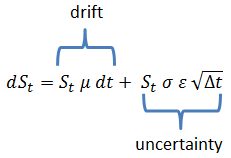

## Estimation of Dockstand Demand

In [28]:
# # Percentage of Pax using Dock Stands rather than Bus Gates
# p_dock = Param["p_dock"]
# # Percentage of Pax travelling within Schengen Area
# p_schengen = Param["p_schengen"]
# # Percentage of Pax travelling from Dock
# p_Dok_A_B = Param["p_Dok_A_B"]
# # average number of passengers carried per air traffic movement
# PAXATM = Param["PAXATM"]


# # Demand at design Hour
# D_per_hour = Demand / (365 * 17)
# ## Contact Stand Demand (ZRH has 75, but not all can be used at once)
# ## Dock A has 17 Contact and 16 Bus Gates

# d = (D_per_hour * p_dock * p_schengen * p_Dok_A_B) / PAXATM
# # print("Contact Stand demad d: ", d)

### Plotting the Dockstand demand

In [29]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     d,
#     Param["Fth"],
#     True,
#     "Dockstand Demand Terminal A at ZRH",
#     "Number of Dock Stands",
#     30,
# )

## Calulation of the ENPV

In [30]:
def Capacity(K0, delta_K, Forecasts):
    """
    This Function returns the Capacity value in Matrix format for a given Initial
    Capacity and delta Capacity Vector, copied according to the number of Forecasts

    Args:
        K0 (int): Initial Capacity
        delta_K (ndarray): delta Capacity Vector
        Forecasts (int): Number of forecasts

    Returns:
        K (ndarray): Capacity Matrix
    """
    # Repeat the delta_K vector 'Forecasts' times
    repeated_delta_K = np.repeat(delta_K[np.newaxis, :], Forecasts, axis=0)

    # Create a cumulative sum array starting from K0 for each forecast
    K = K0 + np.cumsum(repeated_delta_K, axis=1) * 1000000

    return K


def Revenue(K, D, r_K, r_K_rent, r_D):
    """
    This Function calculates the Revenue

    Args:
        K (ndarray): Capacity Vector
        D (ndarray): Demand Matrix
        r_K (float): _description_
        r_K_rent (float): _description_
        r_D (float): _description_

    Returns:
        Total_Revenue (float): Revenue
    """
    diff = K - D
    greater_zero = np.greater(diff, 0).astype(int)
    less_equal_zero = np.less_equal(diff, 0).astype(int)
    # if Overcapacity only amount of Demand can be sold
    rev_overcapacity = greater_zero * (D * r_K + D * r_K_rent + D * r_D)
    # if Undercapacity only available Capacity can be sold
    rev_undercapacity = less_equal_zero * (K * r_K + K * r_K_rent + K * r_D)
    Total_Revenue = rev_overcapacity + rev_undercapacity

    return Total_Revenue


def Cost(K, D, delta_K, co_K, co_D, ci_K, EoS, h):
    """
    This Function calculates the Revenue

    Args:
        K (ndarray): Capacity Vector
        D (ndarray): Demand Matrix
        delta_K (ndarray): delta Capacity Vector
        co_K (float): Operating Cost per Unit of Capacity
        co_D (float): Operating Cost per Unit of Demand
        ci_K (float): Installation Cost per Unit of Capaciy
        EoS (float): Economy of Scale Factor
        h (int): _description_

    Returns:
        Total_Cost (float): Cost
    """
    diff = K - D
    # Penalty Cost Overcapacity
    pc_over = 1
    # Penalty Cost Undercapacity
    pc_under = 1
    # Create an Index Matrix with the Condition for undercapacity
    cos_overcapacity = np.greater(diff, 0).astype(int)
    cos_undercapacity = np.less(diff, 0).astype(int)
    cos_equalcapacity = np.equal(diff, 0).astype(int)

    Total_Cost = (
        ((ci_K * (delta_K) ** EoS) / h)
        + cos_undercapacity * (pc_under + (co_D * K + co_K * K))
        + cos_overcapacity * (pc_over + (co_D * D + co_K * D))
        + cos_equalcapacity * (co_D * D + co_K * K)
    )
    return Total_Cost

In [31]:
def NPV_calculation(K, delta_K, Param):
    """
    This Function calculates the Net Present Value by callng the Revenue and Cost
    Functions

    Args:
        Revenue (ndarray): Total Revenue
        Cost (ndarray): Total Cost
        discount (float): discount rate

    Returns:
        NPV (ndarray): Net Present Value
    """
    # Parameters
    r_D = Param["r_D"]  # Revenues per Unit of Demand per Period
    r_K = Param["r_K"]  # Revenues per Unit of Capacity per Period
    r_K_rent = Param["r_K_rent"]  # Rental Revenues per Unit of Capacity per Period
    co_K = Param["co_K"]  # Operational costs per unit of capacity per period
    co_D = Param["co_D"]  # Operational cost per unit of demand per period
    ci_K = Param["ci_K"]  # Installation cost per unit of capacity
    discount = Param["discount"]  # Discount factor
    EoS = Param["EoS"]  # EoS factor
    h = Param["h"]
    K0 = Param["K0"]
    Forecasts = Param["Forecasts"]

    # Demand
    D = Demand

    # Revenue
    Rev = Revenue(K, D, r_K, r_K_rent, r_D)

    # Cost
    Cos = Cost(K, D, delta_K, co_K, co_D, ci_K, EoS, h)

    # Plus one because Python starts at Zero
    t = 1 + np.arange(0, Param["Fth"], Param["dt"])
    Profit = Rev - Cos
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)

    return NPV


def ENPV(delta_K, Param):
    """
    This Function calculates the Expected Net Present Value by Calling the NPV
    Calculation Funttion

    Args:
        delta_K (ndarray): _description_
        Param (dictionary): Parameter Dictionary

    Returns:
        _type_: _description_
    """
    K0 = Param["K0"]
    Forecasts = Param["Forecasts"]
    K = Capacity(K0, delta_K, Forecasts)
    ENPV = np.mean(NPV_calculation(K, delta_K, Param))

    return ENPV

In [32]:
# Example Value for delta_K

delta_K_Example = Param["delta_K"]

K_Example = Capacity(Param["K0"], delta_K_Example, Param["Forecasts"])

ENPV_Example = ENPV(delta_K_Example, Param)
print("Example ENPV:", ENPV_Example)

Example ENPV: 298873176.53459674


## Optimization Algorithm

In [33]:
def GA(Param):
    """
    This is a Genetic Algorithm seeking to find an optimal delta_K Vector to
    maximise the ENPV

    Args:
        Param (Dictionary): Parameter Dictionary

    Returns:
        delta_K (ndarray): _description_
    """

    # Define the vector of values

    value_vector = Param["allowed_values"]

    # Create the DEAP framework

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

    creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Define the individual initialization function

    def init_individual():

        return np.array([random.choice(value_vector) for _ in range(Param["Fth"])])

    # Register the initialization function and the population function

    toolbox.register(
        "individual", tools.initIterate, creator.Individual, init_individual
    )

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Mutation operator

    def mutate_individual(individual):

        for i in range(len(individual)):

            if random.random() < 0.2:  # Mutation probability

                individual[i] = random.choice(value_vector)

    # Register the mutation operator

    toolbox.register("mutate", mutate_individual)

    # Define the evaluation function

    def evaluate(individual, Param=Param):

        return (ENPV(individual, Param=Param),)

    toolbox.register("evaluate", evaluate)

    # Define the genetic operators

    toolbox.register("mate", tools.cxTwoPoint)

    toolbox.register("select", tools.selTournament, tournsize=3)

    # Set up the genetic algorithm

    population = toolbox.population(n=Param["population"])

    cxpb, mutpb, ngen = 0.5, 0.2, 10

    # Perform the evolution

    for gen in range(ngen):

        offspring = toolbox.select(population, len(population))

        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            if random.random() < cxpb:

                toolbox.mate(child1, child2)

                del child1.fitness.values

                del child2.fitness.values

        for mutant in offspring:

            if random.random() < mutpb:

                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

        fitnesses = map(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):

            ind.fitness.values = fit

        population[:] = offspring

    # Get the best individual

    best_ind = tools.selBest(population, 1)[0]

    return best_ind

In [34]:
Optimized_delta_K = GA(Param)
print("Best individual:", Optimized_delta_K)
print("Best ENPV:", Optimized_delta_K.fitness.values[0])

c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 1\VT1\VT-Python-Files\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 1\VT1\VT-Python-Files\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual: [ 0  6  0 10  0  0  0  6  0  0 10  0  0  8  0  0  0  0  0  0]
Best ENPV: 315509593.6189973


Plotting the Results of the Optimization

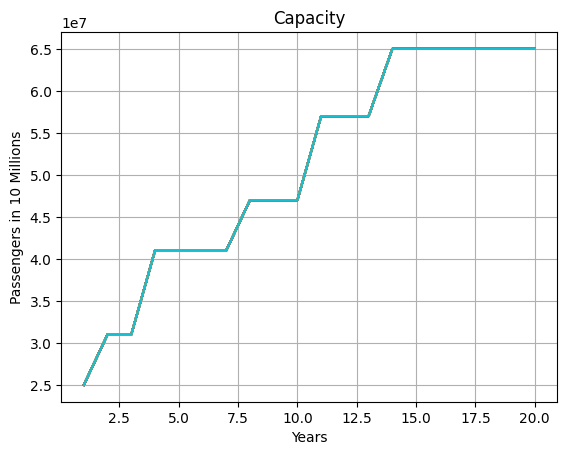

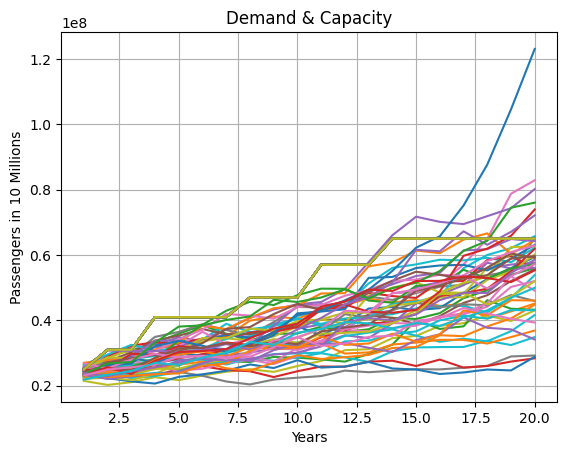

<Figure size 640x480 with 0 Axes>

In [35]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     Demand,
#     Param["Fth"],
#     True,
#     "Demand",
#     "Passengers in 10 Millions",
#     30,
# )

Optimized_K = np.array(Capacity(Param["K0"], Optimized_delta_K, Param["Forecasts"]))
# Zum Vergleich
# New_K = np.array(Capacity(Param["K0"], delta_K_Example, Param["Forecasts"]))

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Optimized_K,
    Param["Fth"],
    True,
    "Capacity",
    "Passengers in 10 Millions",
    30,
)

Optimized_K_Plot = np.vstack([Demand, Optimized_K])


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Optimized_K_Plot,
    Param["Fth"],
    True,
    "Demand & Capacity",
    "Passengers in 10 Millions",
    100,
)

In [36]:
# r_D = Param["r_D"]  # Revenues per Unit of Demand per Period
# r_K = Param["r_K"]  # Revenues per Unit of Capacity per Period
# r_K_rent = Param["r_K_rent"]  # Rental Revenues per Unit of Capacity per Period
# co_K = Param["co_K"]  # Operational costs per unit of capacity per period
# co_D = Param["co_D"]  # Operational cost per unit of demand per period
# ci_K = Param["ci_K"]  # Installation cost per unit of capacity
# discount = Param["discount"]  # Discount factor
# EoS = Param["EoS"]  # EoS factor
# # delta_K0 = 0
# h = Param["h"]
# K0 = Param["K0"]

# # Capacity Vector
# K2 = Capacity(Param["K0"], Optimized_delta_K, Param["Forecasts"])

# # Revenue
# Rev = Revenue(K2, Demand, r_K, r_K_rent, r_D)

# # Cost
# Cos = Cost(K2, Demand, Optimized_delta_K, co_K, co_D, ci_K, EoS, h)

### Flexible NPV Decision Rule

In [37]:
import numpy as np


def Decision_Rule(K0, theta, condition):
    """
    This function creates new Capacity Vectors while considering a decision rule.

    Args:
        D               Demand Vector               np.array
        K0              Initial Capacity            integer
        deltaK_theta    Capacity increase vector    int

    Returns:
        K_Flex          Capacity vector considering a decision rule    np.array

    To call this Function use the following syntax:
        Decision_Rule(D, K0, deltaK_theta)
    """
    D = Demand
    # Creation of an array with the same shape as D initialized with K0
    K_Flex = np.full(D.shape, K0, dtype=D.dtype)

    # Initialize the first column with K0
    K_Flex[:, 0] = K0

    # For loop to iterate over all values of a Scenario
    for t in range(1, D.shape[1]):  # Start from t=1
        # Calculate the Difference Matrix
        diff = K_Flex[:, t - 1] - D[:, t]
        # Create an Index Matrix with the Condition for Overcapacity
        over_capacity = np.greater_equal(diff, condition).astype(int)
        # Create an Index Matrix with the Condition for Undercapacity
        under_capacity = np.less(diff, condition).astype(int)
        # Update K_Flex for the next iteration
        K_Flex[:, t] = over_capacity * K_Flex[:, t - 1] + under_capacity * (
            K_Flex[:, t - 1] + theta
        )

        delta_K_Flex = np.diff((K_Flex / 1000000) - 25)
        delta_K_Flex_Zero = np.insert(delta_K_Flex, 0, 0, axis=1)

    return delta_K_Flex_Zero  # , diff


# decisi = Decision_Rule(Param["K0"], 9000000, -2000)
# print(decisi[1])


def Capacity2(K0, delta_K):
    """
    This Function returns the Capacity in Matrix format for a given Initial
    Capacity and delta Capacity Vector,

    Args:
        K0 (int): Initial Capacity
        delta_K (ndarray): delta Capacity Vector
        Forecasts (int): Number of forecasts

    Returns:
        K (ndarray): Capacity Matrix
    """
    # Create a cumulative sum array starting from K0 for each forecast
    K = K0 + np.cumsum(delta_K, axis=1) * 1000000

    return K


def NPV_Flexible(delta_K, Param):
    K0 = Param["K0"]
    K_Flex = Capacity2(K0, delta_K)
    NPV = NPV_calculation(K_Flex, delta_K, Param)
    return NPV


def ENPV_Flexible(theta, condition, Param):
    K0 = Param["K0"]
    delta_K = Decision_Rule(K0, theta, condition)
    NPV = NPV_Flexible(delta_K, Param)
    ENPV = np.mean(NPV)
    return ENPV

Finding the Optimal Capacity increase value

In [38]:
# def Evaluation(condition, Param):
#     lower = 1000000
#     upper = 10000000  # upper bound in arange is exclusive
#     stepsize = 50000
#     max_enpv = float("-inf")  # Initialize max ENPV to negative infinity
#     max_theta = None

#     for theta in np.arange(lower, upper, stepsize):
#         ENPV = ENPV_Flexible(theta, condition, Param)
#         if ENPV > max_enpv:
#             max_enpv = ENPV
#             max_theta = theta

#     return max_enpv, max_theta


# # Example usage:
# condition = 0
# ENPV_max, theta_max = Evaluation(condition, Param)
# print("Maximum ENPV:", ENPV_max)
# print("Corresponding deltaK_theta:", theta_max)

Finding the Optimal Condition

In [39]:
# def Evaluation2(theta, Param):
#     lower = -2000
#     upper = +2000  # upper bound in arange is exclusive
#     stepsize = 100
#     max_enpv = float("-inf")  # Initialize max ENPV to negative infinity
#     max_condition = None

#     for condition in np.arange(lower, upper, stepsize):
#         ENPV = ENPV_Flexible(theta, condition, Param)
#         if ENPV > max_enpv:
#             max_enpv = ENPV
#             max_condition = condition

#     return max_enpv, condition_max


# # Example usage:
# ENPV_max2, condition_max = Evaluation2(theta_max, Param)
# print("Maximum ENPV:", ENPV_max2)
# print("Corresponding deltaK_theta:", condition_max)

In [40]:
# def Evaluation(Param):
#     lower_theta = 1000000
#     upper_theta = 10000000
#     stepsize_theta = 100000
#     lower_cond = -500000
#     upper_cond = 0
#     stepsize_cond = 50000
#     max_enpv = float("-inf")  # Initialize max ENPV to negative infinity
#     max_theta = None

#     for theta in np.arange(lower_theta, upper_theta, stepsize_theta):
#         for condition in np.arange(lower_cond, upper_cond, stepsize_cond):
#             ENPV = ENPV_Flexible(theta, condition, Param)
#             if ENPV > max_enpv:
#                 max_enpv = ENPV
#                 max_theta = theta
#                 max_cond = condition

#     return max_enpv, max_theta, max_cond


# ENPV_max, theta_max, max_cond = Evaluation(Param)
# print("Maximum ENPV:", ENPV_max)
# print("Corresponding deltaK_theta:", theta_max)
# print("Corresponding cindition:", max_cond)

In [41]:
def Evaluation(Param):
    lower_theta = 1000000
    upper_theta = 10000000
    stepsize_theta = 100000
    lower_cond = -500000
    upper_cond = 0
    stepsize_cond = 50000
    max_enpv = float("-inf")  # Initialize max ENPV to negative infinity
    max_theta = None

    for condition in np.arange(lower_cond, upper_cond, stepsize_cond):
        for theta in np.arange(lower_theta, upper_theta, stepsize_theta):
            ENPV = ENPV_Flexible(theta, condition, Param)
            if ENPV > max_enpv:
                max_enpv = ENPV
                max_theta = theta
                max_cond = condition

    return max_enpv, max_theta, max_cond


ENPV_max, theta_max, max_cond = Evaluation(Param)
print("Maximum ENPV:", ENPV_max)
print("Corresponding deltaK_theta:", theta_max)
print("Corresponding cindition:", max_cond)

Maximum ENPV: 320760431.78655714
Corresponding deltaK_theta: 9000000
Corresponding cindition: -450000


In [42]:
delta_K_Flex = Decision_Rule(Param["K0"], theta_max, max_cond)
NPV_Flex = NPV_Flexible(delta_K_Flex, Param)
ENPV_Flex = ENPV_Flexible(theta_max, max_cond, Param)

print("ENPV Decision Rule: ", ENPV_Flex)

ENPV Decision Rule:  320760431.78655714


In [43]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     K_Flex,
#     Param["Fth"],
#     False,
#     "Best delta Capacity",
#     "Unit Capacity (1 Million)",
#     90,
# )

## Plots

In [44]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     Optimized_delta_K,
#     Param["Fth"],
#     False,
#     "Best delta Capacity",
#     "Unit Capacity (1 Million)",
#     30,
# )

# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     Demand,
#     Param["Fth"],
#     True,
#     "Demand",
#     "Passengers in 10 Millions",
#     30,
# )

# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     Optimized_K,
#     Param["Fth"],
#     False,
#     "Optimized Capacity",
#     "Passengers in 10 Millions",
#     30,
# )


# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     Rev,
#     Param["Fth"],
#     True,
#     "Revenue",
#     "USD",
#     30,
# )


# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     -Cos,
#     Param["Fth"],
#     True,
#     "Cost",
#     "USD",
#     30,
# )


# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     (Rev - Cos),
#     Param["Fth"],
#     True,
#     "Profit",
#     "USD",
#     30,
# )

## Target Curves

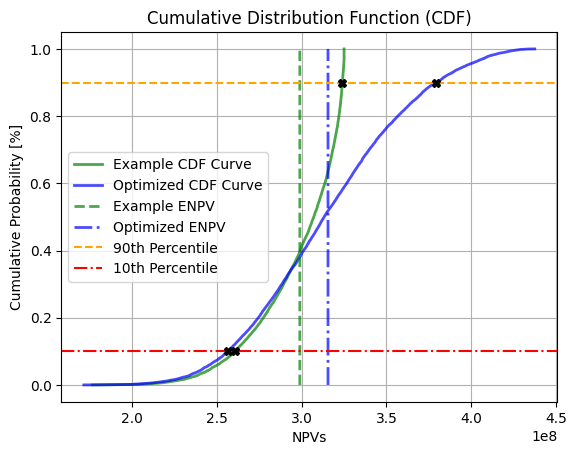

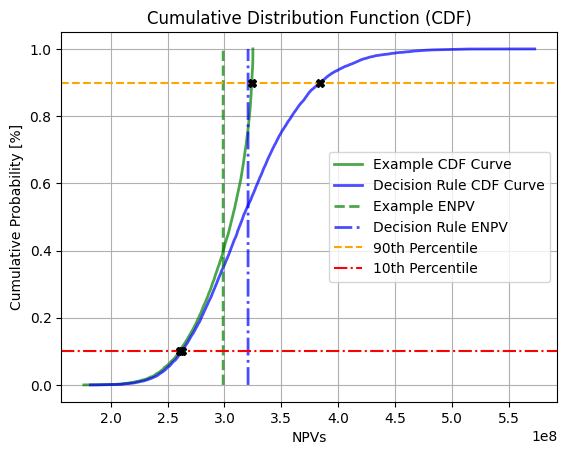

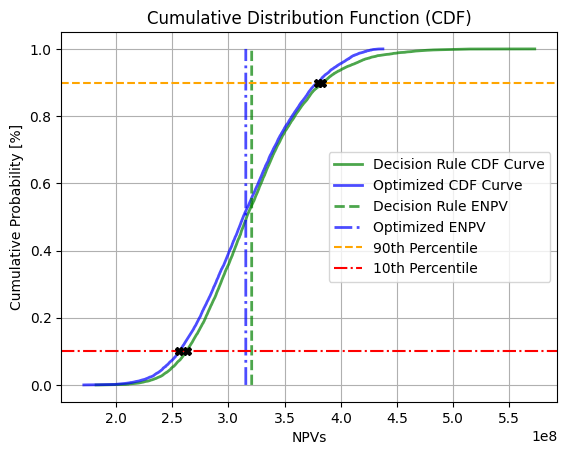

Percentiles (10 and 90) for Example + Optimized NPVs = [260620302.34282634, 323972982.8860556, 256435021.72712305, 379487948.2247634]
Percentiles (10 and 90) for Example + Decision Rule NPVs = [260620302.34282634, 323972982.8860556, 262804405.10834512, 383753464.075769]
Percentiles (10 and 90) for Decision Rule + Optimized NPVs = [262804405.10834512, 383753464.075769, 256435021.72712305, 379487948.2247634]


In [45]:
# Plotting the CDF for the First Decision Rule
Percentiles = fn.CDF_Plot(
    NPV_calculation(K_Example, delta_K_Example, Param),
    NPV_calculation(
        Optimized_K,
        Optimized_delta_K,
        Param,
    ),
)
Percentiles1 = fn.CDF_Plot(
    NPV_calculation(K_Example, delta_K_Example, Param),
    NPV_Flex,
    "Example CDF Curve",
    "Decision Rule CDF Curve",
    "Example ENPV",
    "Decision Rule ENPV",
)


Percentiles2 = fn.CDF_Plot(
    NPV_Flex,
    NPV_calculation(Optimized_K, Optimized_delta_K, Param),
    "Decision Rule CDF Curve",
    "Optimized CDF Curve",
    "Decision Rule ENPV",
)
# # Plotting the CDF for the Second Decision Rule
# Percentiles1 = fn.CDF_Plot(Traditional_NPV, Flex_NPV_est)
print("Percentiles (10 and 90) for Example + Optimized NPVs =", Percentiles)
print("Percentiles (10 and 90) for Example + Decision Rule NPVs =", Percentiles1)
print("Percentiles (10 and 90) for Decision Rule + Optimized NPVs =", Percentiles2)

### Stopping the Runtime

In [46]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", round(total_run_time, 2), "s")

Total Runtime = 202.49 s
